In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from numpy import linalg as LA
#
%matplotlib inline
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings("ignore")

# Data Smoothing
* [Savitzky-Golay Filter 1D](#Savitzky-Golay-Filter-1D)
* [Savitzky-Golay Filter 2D](#Savitzky-Golay-Filter-2D)

Let $f(x)=\sin(x/2)\cos(x/2)$ with $0\leq x \leq 3\pi$, and this functions can be discretized over an interval $[a,b] =   [0,3\pi]$. For example, we can set $N = 100$ and let $\Delta x = (3\pi-0)/N$. Thus,

In [2]:
N = 100
a = 0
b = 3*np.pi
dx = (b - a)/N
x = np.arange(a, b, dx)

Alternatively, we could simply this process by using linspace

In [3]:
x = np.linspace(a, b, N)

Discritizing the function

In [4]:
f= lambda x: np.sin(x/2)*np.cos(x/2)
y = f(x)

To create a nosiy version of this fuction, one can consider adding noise to the data using [numpy.random.normal](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html) given $\mu = 0$ and $\sigma = 0.1$, mean and standard deviation respectively.

In [5]:
mu = 0
sigma = 0.1
noise = np.random.normal(mu, sigma, len(x))
y_noise = y + noise

## Savitzky-Golay Filter 1D

Using [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) from scipy [prackage](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html), we can reduce the impact of the generated random noise.

Using a fourth-order polynomial, we get

In [6]:
y_filtered = signal.savgol_filter(y_noise, window_length = 23, polyorder = 4)

Let's plot the data.

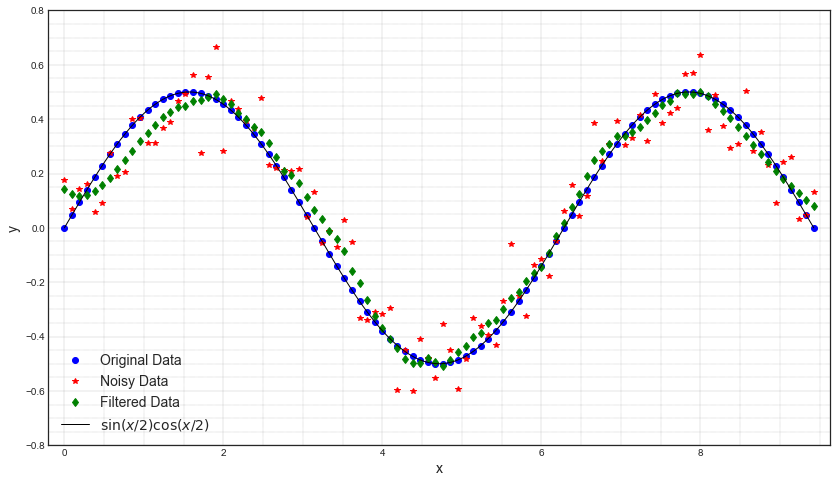

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=False)

_ = ax.set_xlabel('x', fontsize = 14)
_ = ax.set_ylabel('y', fontsize = 14)
_ = ax.set_xlim(x[0]-0.2,x[-1]+0.2)
_ = ax.set_ylim(-0.8,0.8)

_ = ax.set_axisbelow(True)
_ = ax.minorticks_on()
_ = ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
_ = ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
_ = ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

_ = ax.plot(x, y, 'bo', label='Original Data', linewidth=1)
_ = ax.plot(x, y_noise, 'r*',label='Noisy Data', linewidth=1)
_ = ax.plot(x, y_filtered, 'gd',label='Filtered Data', linewidth=1)
_ = ax.plot(np.linspace(a, b, N**2), f(np.linspace(a, b, N**2)),
              'k',label='$\sin(x/2)\cos(x/2)$', linewidth=1)
_ = ax.legend(fontsize = 14)

Furthermore, let's use $||.||_{\infty}$ for mesuring the accuracy.

$||y-y_{noise}||_{\infty}$ =

In [8]:
LA.norm(np.abs(y-y_noise), np.inf)

0.249112210121532

$||y-y_{filtered}||_{\infty}$ =

In [9]:
LA.norm(np.abs(y-y_filtered), np.inf)

0.14413201576688175

## Savitzky-Golay Filter 1D

For two dimmentional, we can use the following function form [this link](https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay)

In [10]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')     

In [11]:
x, y = np.mgrid[-1e2:1e2, -1e2:1e2]
z_exact = np.sin((x**2+y**2)/500.)
z_noise = z_exact+ np.random.normal(size=x.shape)
z_filtered = sgolay2d(z_noise, window_size = 23, order = 4)

In [12]:
r = 500.
f= lambda x, y: np.cos((x**2)/r + (y**2)/r)

In [13]:
x, y = x, y = np.mgrid[-1e2:1e2, -1e2:1e2]
z = f(x,y)
z_noise = z + np.random.normal(size=x.shape)
z_filtered = sgolay2d(z_noise, window_size = 23, order = 4)

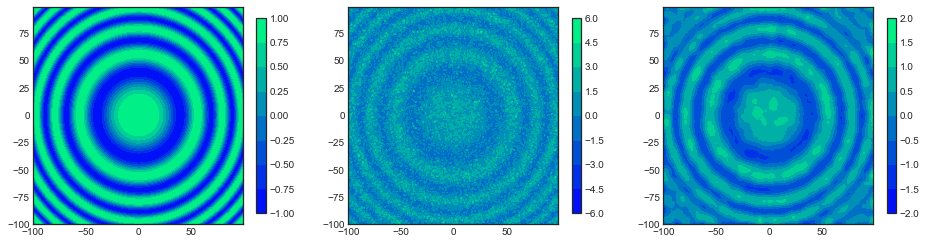

In [14]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
color_map = 'winter'
cs = ax[0].contourf(x, y, z, cmap = color_map)
_ = fig.colorbar(cs, ax=ax[0], shrink=0.9)
cs = ax[1].contourf(x, y, z_noise, cmap = color_map)
_ = fig.colorbar(cs, ax=ax[1], shrink=0.9)
cs = ax[2].contourf(x, y, z_filtered, cmap = color_map)
_ = fig.colorbar(cs, ax=ax[2], shrink=0.9)

$||z-z_{noise}||_{\infty}$ =

In [15]:
LA.norm(np.abs(z-z_noise), np.inf)

183.36576518872573

$||z-z_{filtered}||_{\infty}$ =

In [16]:
LA.norm(np.abs(z-z_filtered), np.inf)

121.9703404349248

* * *